In [26]:
from comet_ml import Experiment
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

load_dotenv('../.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question5/XGboost_FeaturesSelection')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibrationDisplay

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import seaborn as sn
from matplotlib.pyplot import figure
from sklearn import linear_model
from sklearn import feature_selection 
from sklearn.pipeline import Pipeline


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/meriembchaaben/ift6758/7e07ee5f5db34a8fa56232793ef5adda
COMET INFO:   Others:
COMET INFO:     Name : Question5/XGboost_FeaturesSelection
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     constant        : 1
COMET INFO:     end_iteration   : 100
COMET INFO:     objective       : binary:logistic
COMET INFO:     random_state    : 1
COMET INFO:     rank            : 0
COMET INFO:     strategy        : uniform
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (913.23 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:    

In [18]:
# Read and preprocess data
df = pd.read_csv('../data/AllSeasonsM2Q2.csv')

df = df.drop('Unnamed: 0', 1)
df = df[['distance', 'angle', 'Goal']]
df = df.rename({'Goal': 'is_goal'}, axis=1)
df = df[~(df['is_goal'].isnull() | df['distance'].isnull() | df['angle'].isnull())] #remove after fix
df['is_goal'] = df['is_goal'].astype(np.int64)
df.head()

,distance,angle,is_goal
0,13.000000,67.380135,0
1,13.341664,167.005383,0
2,76.157731,60.068488,0
3,57.974132,75.004921,0
4,61.717096,63.019769,0


In [16]:
df.columns

Index(['distance', 'angle', 'is_goal'], dtype='object')

In [19]:
X = df.drop('is_goal', 1)
y = df['is_goal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train[['distance', 'angle']]

,distance,angle
143124,52.497619,72.255328
9667,29.427878,9.782407
285044,37.121422,94.635463
50783,49.000000,90.000000
241011,10.049876,95.710593
...,...,...
122591,35.805028,125.909723
304154,58.051701,79.077195
152327,9.433981,57.994617
117964,57.271284,65.224859


### Question-1:

In [20]:
### XGBoost on distance+angle ###

X_train1 = X_train[['distance', 'angle']].to_numpy().reshape(-1, 2)
X_val1 = X_val[['distance', 'angle']].to_numpy().reshape(-1, 2)

xgb_clf1 = XGBClassifier().fit(X_train1, y_train)


train_score1 = xgb_clf1.score(X_train1, y_train)
val_score1 = xgb_clf1.score(X_val1, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

Training accuracy: 0.9050266312945303
Validation accuracy: 0.9063113145846958


In [22]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train1, y_train)

train_score0 = random_clf.score(X_train1, y_train)
val_score0 = random_clf.score(X_val1, y_val)

print(f'Training accuracy: {train_score0}')
print(f'Validation accuracy: {val_score0}')

Training accuracy: 0.4999611669534862
Validation accuracy: 0.5012262916939176


XGBoost (trained on distance+angle): ROC AUC=0.712
Random: ROC AUC=0.500


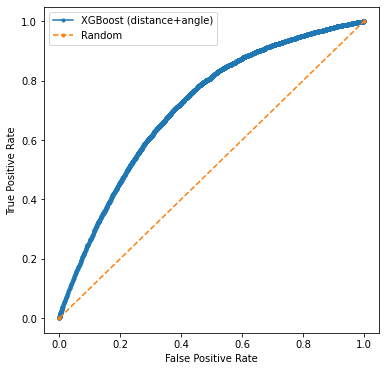

In [23]:
### ROC curve - AUC metric ###

xgb_probs1 = xgb_clf1.predict_proba(X_val1[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val1[:, :])[:,1]


xgb_auc1 = roc_auc_score(y_val, xgb_probs1)
random_auc = roc_auc_score(y_val, random_probs)

print('XGBoost (trained on distance+angle): ROC AUC=%.3f' % (xgb_auc1))
print('Random: ROC AUC=%.3f' % (random_auc))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_val, xgb_probs1)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (distance+angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

In [4]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

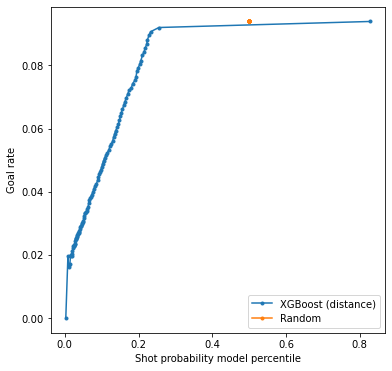

In [7]:
### goal_rate = F(shot probability model percentile) ###



percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_1.png')

plt.show()

In [3]:

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates



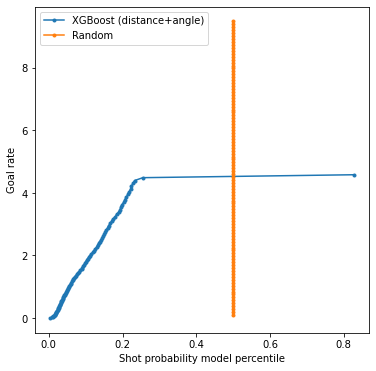

In [8]:
### cumulative portion of goals = F(shot probability model percentile) ###

percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance+angle)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_2.png')

plt.show()

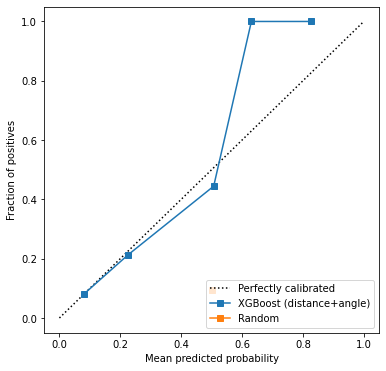

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf1, X_val1, y_val, label='XGBoost (distance+angle)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val1, y_val, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()

In [70]:
df.columns

Index(['Unnamed: 0', 'index', 'eventType', 'period', 'periodTime',
       'periodType', 'gameID', 'teamOfShooter', 'homeOrAway', 'xCoord',
       'yCoord', 'shooter', 'goalie', 'shotType', 'emptyNet', 'strength',
       'season', 'rinkSide', 'gameType', 'totalPlayTime', 'lastEventType',
       'lastEventPeriod', 'lastEventPeriodTime', 'lastEventXCoord',
       'lastEventYCoord', 'Goal', 'EmptyNet', 'distanceFromNet', 'angle',
       'gameSeconds', 'lastEventGameSeconds', 'timeFromLastEvent',
       'distanceFromLastEvent', 'rebound', 'lastEventAngle',
       'changeInAngleShot', 'speed'],
      dtype='object')

### Question-2: 
Game seconds-
Game period-
Coordinates (x,y, separate columns)-
Shot distance-
Shot angle-
Shot type-

Last event type-
Coordinates of the last event (x, y, separate columns)-
Time from the last event (seconds)-
Distance from the last event-
Rebound (bool): -
Change in shot angle-
“Speed”-

In [38]:
df=pd.read_csv('../data/trainingSet.csv')


df['rebound']=df['rebound'].astype(int)

FinalDf = df[['gameSeconds','period','xCoord','yCoord','distanceFromNet','angle','shotType','lastEventType', 'lastEventXCoord',
       'lastEventYCoord','lastEventGameSeconds','distanceFromLastEvent','rebound', 
       'changeInAngleShot', 'speed','Goal']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()

FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)

#Frame is the dataset used fpr xgboost later
Frame=pd.concat([FinalDf,obj_df],axis=1)



df_f = Frame.dropna()
print(df_f.shape)
print(df_f.columns)
X = df_f.drop('Goal',axis=1)
y = df_f['Goal'].to_numpy()


(55365, 16)
Index(['gameSeconds', 'period', 'xCoord', 'yCoord', 'distanceFromNet', 'angle',
       'lastEventXCoord', 'lastEventYCoord', 'lastEventGameSeconds',
       'distanceFromLastEvent', 'rebound', 'changeInAngleShot', 'speed',
       'Goal', 'shotType', 'lastEventType'],
      dtype='object')


####  Split the data , this split is performed only once (same events will be used as train/test for each model) 

In [45]:
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [71]:
### 
def displayFigures(Models,X_train,Y_train,X_val,Y_val,Text_label,X_trainAll=X_train,Y_trainAll=y_train,X_valAll=x_val,Y_valAll=y_val):
    
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    
    random_clf = DummyClassifier(strategy="uniform").fit(X_trainAll, Y_trainAll)

    train_score2 = random_clf.score(X_trainAll, Y_trainAll)
    val_score2 = random_clf.score(X_valAll, Y_valAll)

    print(f'Training accuracy: {train_score2}')
    print(f'Validation accuracy: {val_score2}')
    
    random_probs = random_clf.predict_proba(X_valAll.to_numpy().reshape(-1, len(X_valAll.columns))[:, :])[:,1]

    random_auc = roc_auc_score(Y_valAll, random_probs)

    print('Random: ROC AUC=%.3f' % (random_auc))


    random_fpr, random_tpr, _ = roc_curve(Y_valAll, random_probs)
    axs[0, 0].plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')
    axs[0, 0].set_xlabel('False Positive Rate')
    axs[0, 0].set_ylabel('True Positive Rate')
    axs[0, 0].legend()
    
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, Y_valAll)
    axs[0, 1].plot(percentiles2, rates2, marker='.', label='Random')
    axs[0, 1].set_xlabel('Shot probability model percentile')
    axs[0, 1].set_ylabel('Goal rate')
    axs[0, 1].legend()
    
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, Y_valAll)
    axs[1, 0].plot(percentiles2, rates2, marker='.', label='Random')
    axs[1, 0].set_xlabel('Shot probability model percentile')
    axs[1, 0].set_ylabel('Goal rate')
    axs[1, 0].legend()  
    
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_valAll, Y_valAll, label='Random', ax=axs[1, 1])

    for idx, Model in enumerate(Models):
        print(Text_label[idx])
        xgb_probs = Model.predict_proba(X_val[idx][:, :])[:,1]
        xgb_auc = roc_auc_score(Y_val[idx], xgb_probs)

        print(Text_label[idx]+': ROC AUC=%.3f' % (xgb_auc))

        xgb_fpr1, xgb_tpr1, _ = roc_curve(Y_val[idx], xgb_probs)


        axs[0, 0].plot(xgb_fpr1, xgb_tpr1, marker='.', label=Text_label[idx])


        percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs, Y_val[idx])


        axs[0, 1].plot(percentiles1, rates1, marker='.', label=Text_label[idx])

        percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs, Y_val[idx])


        axs[1, 0].plot(percentiles1, rates1, marker='.', label=Text_label[idx])
        
        disp1 = CalibrationDisplay.from_estimator(Model, X_val[idx], Y_val[idx], label=Text_label[idx], ax=axs[1, 1])

    # plt.savefig('../figures/calibration_diagram.png')

    #plt.show()

### XGBoost using all features only encoding  (no feature selection) 

Training accuracy: 0.9169827508353653
Validation accuracy: 0.9004786417411722


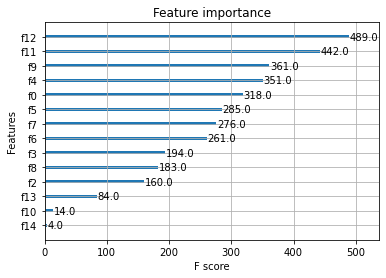

In [47]:
### XGBoost using all features  ###
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint



X_train1XG_All = X_train.to_numpy().reshape(-1, len(X_train.columns))
X_val1XG_All = x_val.to_numpy().reshape(-1, len(X_train.columns))

xgb_clf = XGBClassifier().fit(X_train1XG_All, y_train)


plot_importance(xgb_clf)


train_score1 = xgb_clf.score(X_train1XG_All, y_train)
val_score1 = xgb_clf.score(X_val1XG_All, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
#displayFigures(xgb_clf,X_train1XG_All,y_train,X_val1XG_All,y_val,"XGBOOST_AllFeatures")

In [7]:
exp.log_metrics({'Training accuracy': train_score1, 'Validation accuracy': val_score1})

### Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [73]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

NameError: name 'plt' is not defined

Training accuracy: 0.9067777476745236
Validation accuracy: 0.9002077124537162


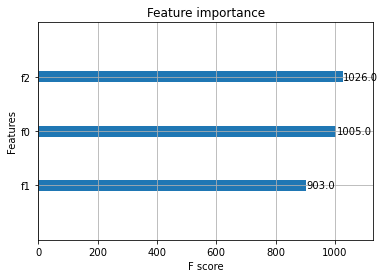

In [48]:
#### Run XGboost with features that are pushing the prediction higher with xgboost:
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint


X_trainXG_SHAP_=X_train[['changeInAngleShot','gameSeconds','speed']]
X_valXG_SHAP=x_val[['changeInAngleShot','gameSeconds','speed']]

X_trainXG_SHAP = X_trainXG_SHAP_.to_numpy().reshape(-1, len(X_trainXG_SHAP_.columns))
X_val1XG_SHAP = X_valXG_SHAP.to_numpy().reshape(-1, len(X_trainXG_SHAP_.columns))

xgb_cl_SHAP = XGBClassifier().fit(X_trainXG_SHAP, y_train)


plot_importance(xgb_cl_SHAP)


train_score1 = xgb_cl_SHAP.score(X_trainXG_SHAP, y_train)
val_score1 = xgb_cl_SHAP.score(X_val1XG_SHAP, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
#displayFigures(xgb_cl_SHAP,X_trainXG_SHAP_,y_train,X_val1XG_SHAP,y_val,"XGBOOST_selectedFeatures_SHAP")

Training accuracy: 0.5040413618712183
Validation accuracy: 0.5007676329811253
Random: ROC AUC=0.500
XGBOOST_AllFeatures
XGBOOST_AllFeatures: ROC AUC=0.762
xgb_cl_SHAP
xgb_cl_SHAP: ROC AUC=0.609


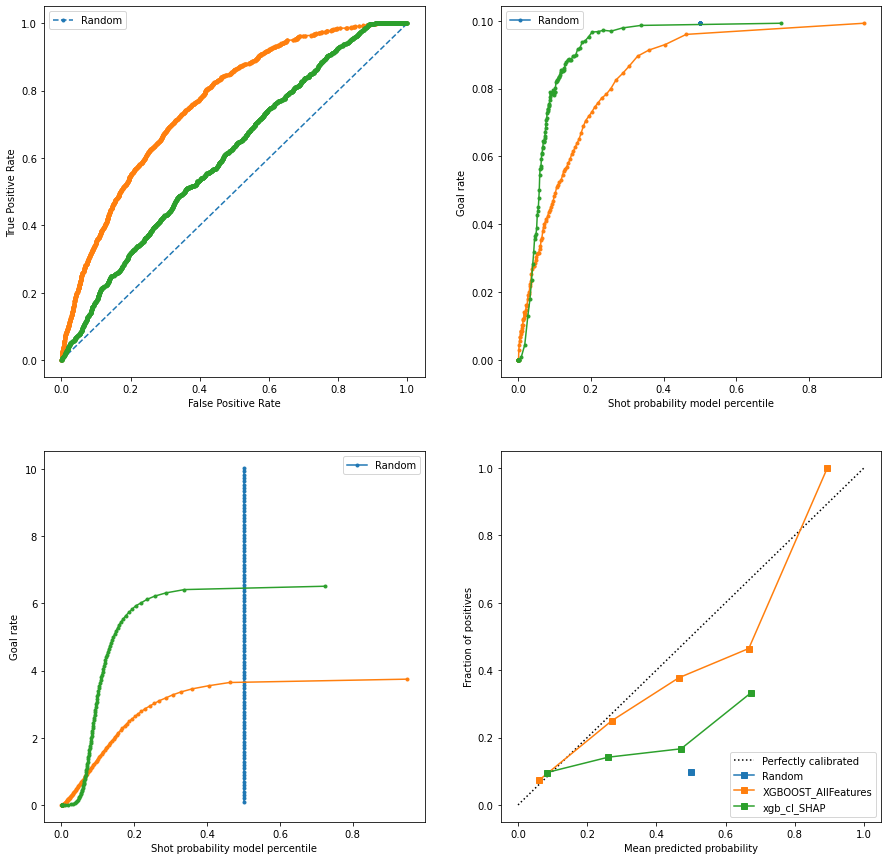

In [72]:
displayFigures([xgb_clf,xgb_cl_SHAP],[X_train1XG_All,X_trainXG_SHAP_],[y_train,y_train],[X_val1XG_All,X_val1XG_SHAP],[y_val,y_val],["XGBOOST_AllFeatures","xgb_cl_SHAP"])

## Analyzing correlation between:  
**features to features (redundancy identification) 
**features to target (relevance identification)

In [11]:
### should run previous part to have Frame
df_f = Frame.dropna()

X = df_f.drop('Goal',axis=1)
y = df_f['Goal'].to_numpy()
df_f.shape

(56164, 18)

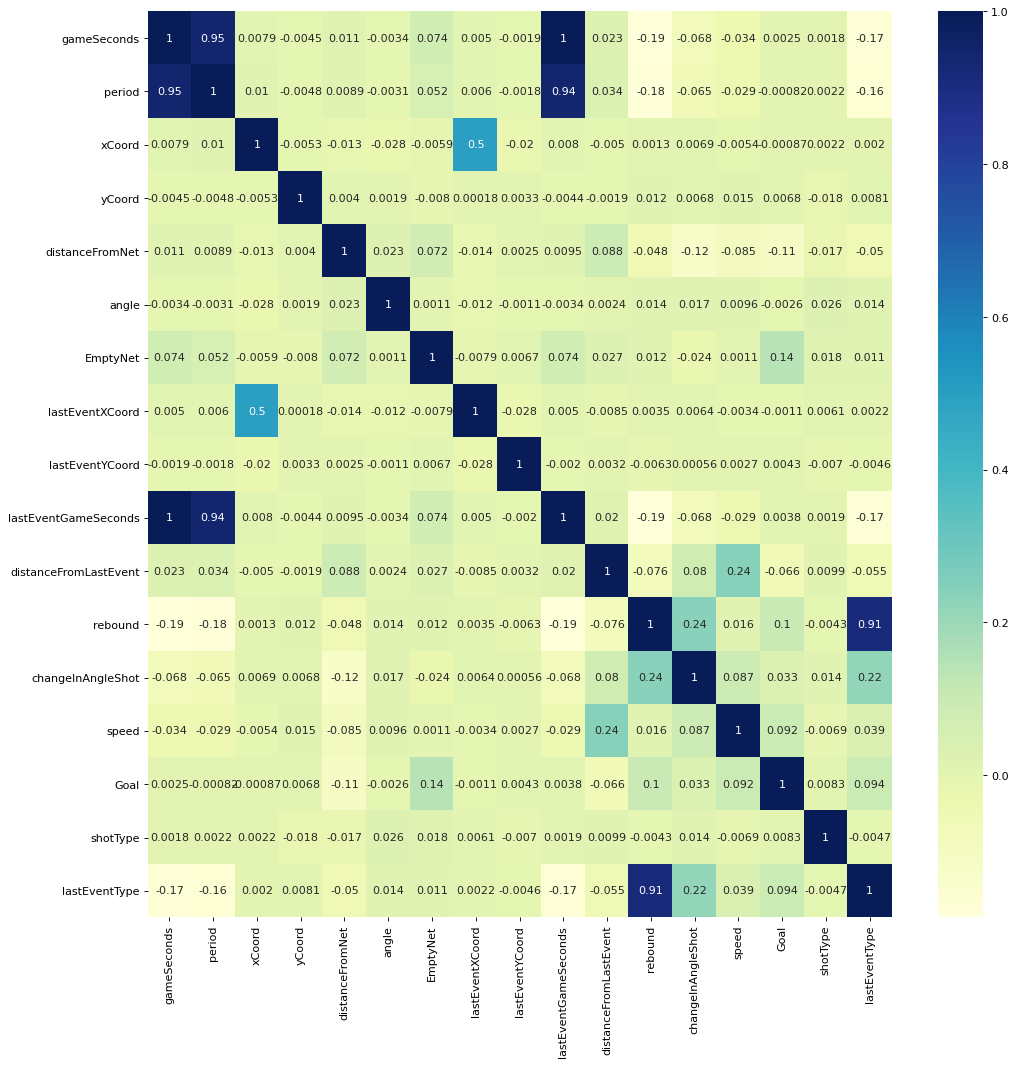

In [7]:
corrMatrix = df_f.corr()

figure(figsize=(15, 15), dpi=80)
sn.heatmap(corrMatrix, annot=True,cmap="YlGnBu")
plt.show()

## Lasso

In [39]:
clf = linear_model.Lasso(alpha=0.1)
selector = feature_selection.SelectFromModel(estimator=clf,threshold="mean").fit(X_train,y_train)
selected_feature_indices = np.where(selector._get_support_mask())[0] 
res_list = [X_train.columns[i] for i in selected_feature_indices] 
res_list

['distanceFromNet', 'distanceFromLastEvent', 'speed']

### XGBoost classifier using selected featurs by Lasso:

Training accuracy: 0.9072067190463289
Validation accuracy: 0.8986724464914657
Training accuracy: 0.4982841145127788
Validation accuracy: 0.49589090580691775
XGBoost (trained on all ffeatures): ROC AUC=0.704
Random: ROC AUC=0.500


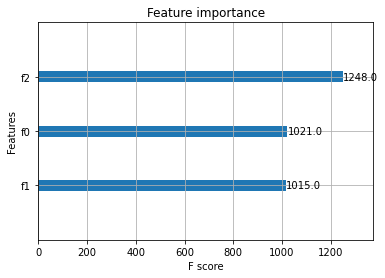

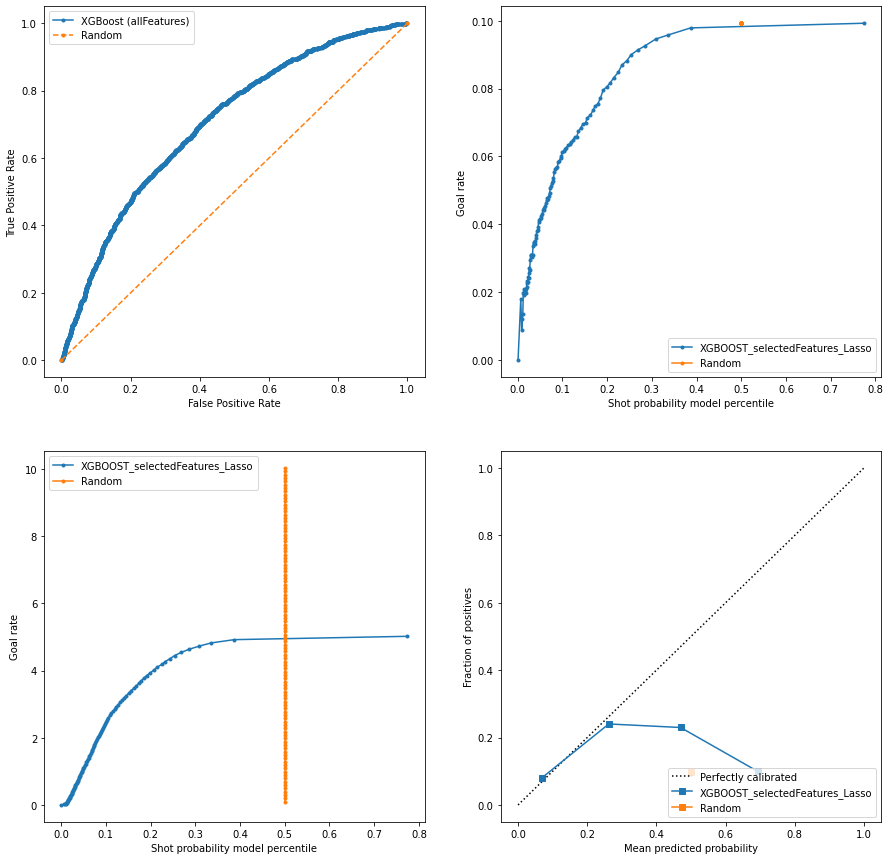

In [43]:
### XGBoost using all features  ###
from xgboost import plot_importance
from matplotlib import pyplot
from pprint import pprint

x_select=X[['distanceFromNet','distanceFromLastEvent','speed']]

X_trainXG_select, X_valXG_select, y_trainXG_select, y_valXG_select = train_test_split(x_select, y, test_size=0.2, random_state=0)


X_train1XG_select = X_trainXG_select.to_numpy().reshape(-1, len(X_trainXG_select.columns))
X_val1XG_select = X_valXG_select.to_numpy().reshape(-1, len(X_trainXG_select.columns))

xgb_clf_select = XGBClassifier().fit(X_train1XG_select, y_trainXG_select)


plot_importance(xgb_clf_select)


train_score1 = xgb_clf_select.score(X_train1XG_select, y_trainXG_select)
val_score1 = xgb_clf_select.score(X_val1XG_select, y_valXG_select)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')
#displayFigures(xgb_clf_select,X_train1XG_select,y_trainXG_select,X_val1XG_select,y_valXG_select,"XGBOOST_selectedFeatures_Lasso")

In [41]:
from sklearn.linear_model import LogisticRegression
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', XGBClassifier())
])
clf.fit(X_train, y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
train_score = clf.score(X_train, y_train)

print("Accuracy: %.1f%%" % ( train_score*100.0))

print(f'Validation accuracy: {accuracy*100.0}')

[17:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Accuracy: 90.9%
Validation accuracy: 89.97561636412897


In [38]:


 
# load data

X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
        #train
    accuracyTrain= selection_model.score(select_X_train, y_train)
        #validation
    select_X_test = selection.transform(x_val)
    predictions = selection_model.predict(select_X_test)
    accuracyValidation = accuracy_score(y_val, predictions)
    print("Thresh=%.3f, n=%d, accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracyTrain*100.0))
    print("Thresh=%.3f, n=%d, Validation: %.2f%%" % (thresh, select_X_train.shape[1], accuracyValidation*100.0))
    

[17:08:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 90.26%
[17:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=16, accuracy: 92.00%
Thresh=0.000, n=16, Validation: 90.26%
[17:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to res